In [1]:
import torch

from pkg.datasets import IDSDataset
from pkg.lit_vae import LitIDSVAE

In [2]:
from torchvision import transforms, utils
from tqdm import tqdm
import pickle
import pandas as pd
# Маппинги айпи адресов
with open('Data/sip_map.pkl', 'rb') as f:
    sip_map = pickle.load(f)
with open('Data/dip_map.pkl', 'rb') as f:
    dip_map = pickle.load(f)

In [3]:
PATH = 'Models/vae-final-epoch=26-step=68421.ckpt'
model = LitIDSVAE.load_from_checkpoint(PATH, sip_map=sip_map, dip_map=dip_map, map_location=torch.device('cpu'))

In [4]:
from torchvision import transforms, utils
from tqdm import tqdm, tqdm_notebook
import pickle
import pandas as pd

ds_test = IDSDataset('Data/all_test.csv', sip_map, dip_map, only_anomaly=False, transform=True,
                    stat=pd.read_csv('Data/all_stat.csv').rename({0:'count', 1:'mean', 2:'std', 3:'min', 4:'25%', 5:'50%', 6:'75%', 7:'max'}))
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=3**5,
                        shuffle=False, num_workers=4)

In [11]:
device = torch.device('cpu')
model = model.to(device)

In [12]:
losses = []
mses =[]
labels = []
with torch.no_grad():
    model.eval()
    for row in tqdm(test_dataloader):
        categorical = row[0].to(device)
        continuous =  row[1].to(device).unsqueeze(-2)
        labels.append(row[2])
        x = model.categorical_emb(categorical, continuous) 
        x_hat, mu, logvar = model(x)
        dist = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = -1)
        mse = torch.sum(torch.nn.functional.mse_loss(x_hat, continuous, reduction='none'), dim=-1)
        mses.append(mse.squeeze())
        # dist = torch.mean(dist, dim=-1)
        losses.append(dist.squeeze())

100%|██████████| 871/871 [02:11<00:00,  6.60it/s]


In [13]:
losses[0].shape

torch.Size([243])

In [14]:
new_dict = {'dist': torch.cat(losses).cpu().numpy(), 'mse':torch.cat(mses).cpu().numpy()}
labels_cat = torch.cat(labels) != 0
# losses_cat = torch.cat(val_losses).cpu()
test_out = pd.DataFrame({ 'is_benign':labels_cat, 'attack_class': torch.cat(labels).numpy(), **new_dict})
test_out.to_csv('test_results_vae.csv')

In [15]:
import numpy as np
new_dict['dist'][np.isnan(new_dict['dist'])] = 0
new_dict['dist'][np.isinf(new_dict['dist'])] = 1e+6

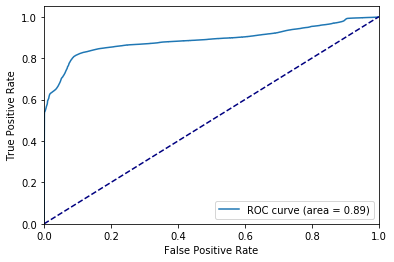

In [16]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(labels_cat.int().numpy(), new_dict['mse'])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

In [17]:
thresholds.shape

(52503,)

In [18]:
IDX = -10
threshold = thresholds[IDX]
test_out['predicted'] = test_out.dist < threshold

In [19]:
from sklearn.metrics import classification_report, f1_score
y_gts = test_out['is_benign']
y_preds = test_out['predicted']
rep = classification_report(y_gts, y_preds, target_names=['Attack', 'No attack'])
print(rep)

              precision    recall  f1-score   support

      Attack       0.75      1.00      0.86    158628
   No attack       0.00      0.00      0.00     53007

    accuracy                           0.75    211635
   macro avg       0.37      0.50      0.43    211635
weighted avg       0.56      0.75      0.64    211635



/home/akerika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=56316f98-13a2-452c-be31-8997c1e2f7a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>